In [1]:
!pip install yfinance
!pip install statsmodels
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

In [3]:

tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
start_date = "2018-01-01"
end_date = "2023-12-31"


data = yf.download(tickers, start=start_date, end=end_date)


print("Downloaded Data Head:")
print(data.head())


print("\nMissing values before handling:")
print(data.isnull().sum())


data_filled = data.ffill()


print("\nMissing values after handling:")
print(data_filled.isnull().sum())


stock_data = pd.DataFrame()
stock_data['Close'] = data_filled['Close']['AAPL']
stock_data.index = pd.to_datetime(stock_data.index)
print("\nAAPL Stock Data Head:")
print(stock_data.head())
print("\nAAPL Stock Data Info:")
print(stock_data.info())



[*********************100%***********************]  5 of 5 completed

Downloaded Data Head:
Price           Close                                                   High  \
Ticker           AAPL       AMZN       GOOG       MSFT       TSLA       AAPL   
Date                                                                           
2018-01-02  40.524345  59.450500  53.059353  79.633507  21.368668  40.533757   
2018-01-03  40.517284  60.209999  53.930225  80.004120  21.150000  41.063069   
2018-01-04  40.705490  60.479500  54.125523  80.708290  20.974667  40.809001   
2018-01-05  41.168938  61.457001  54.914188  81.708908  21.105333  41.255979   
2018-01-08  41.016022  62.343498  55.148846  81.792274  22.427334  41.312437   

Price                                                   ...       Open  \
Ticker           AMZN       GOOG       MSFT       TSLA  ...       AAPL   
Date                                                    ...              
2018-01-02  59.500000  53.156006  79.967051  21.474001  ...  40.030320   
2018-01-03  60.274502  54.120042  80.1523


--- Exploratory Data Analysis (EDA) ---


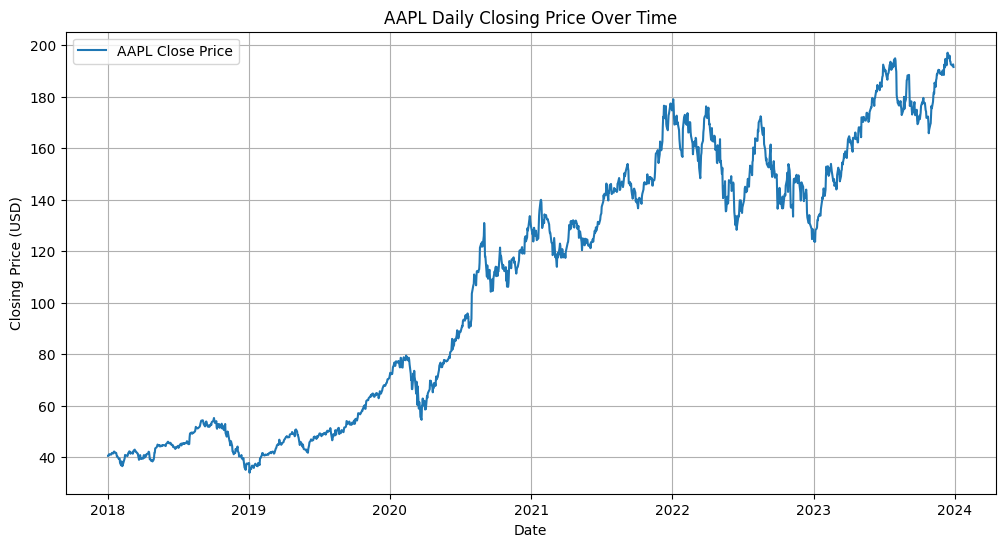

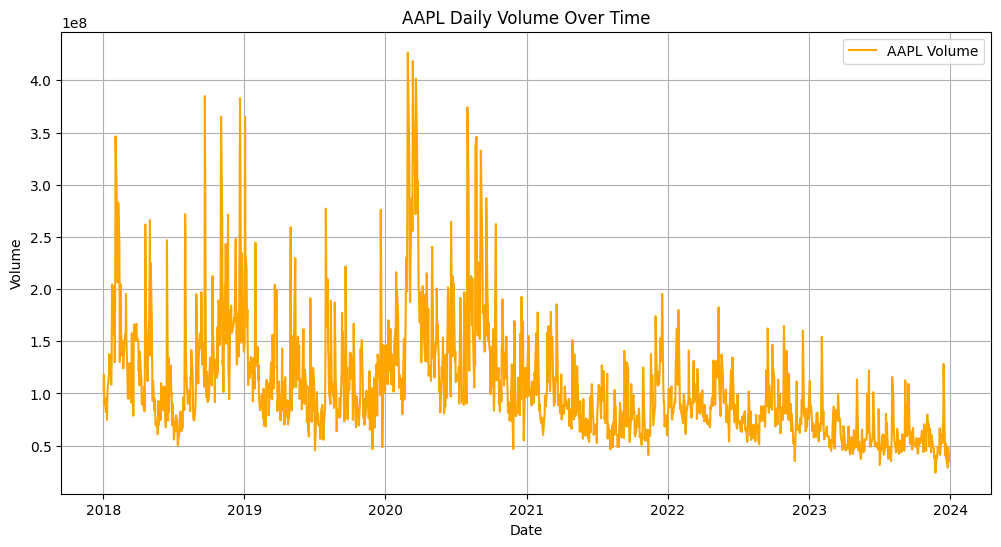

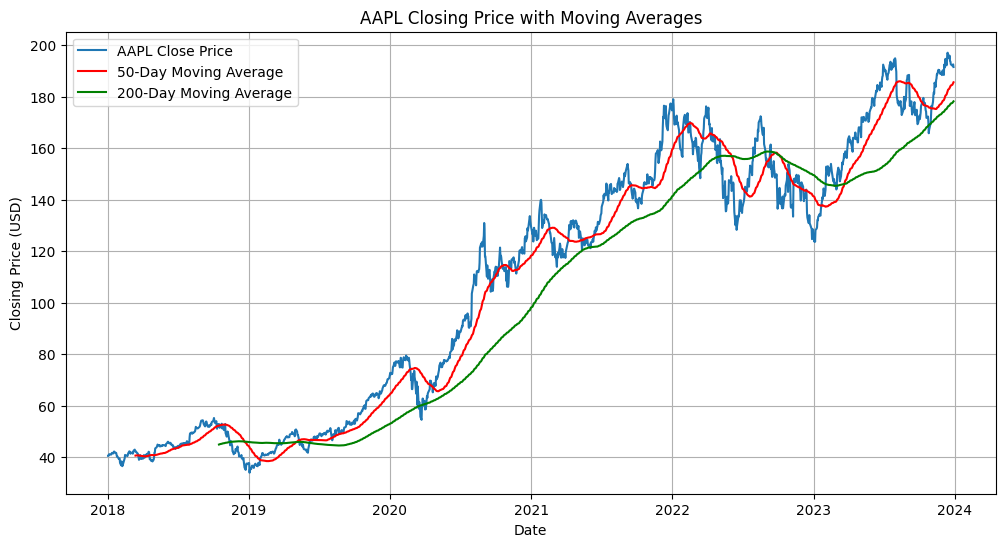

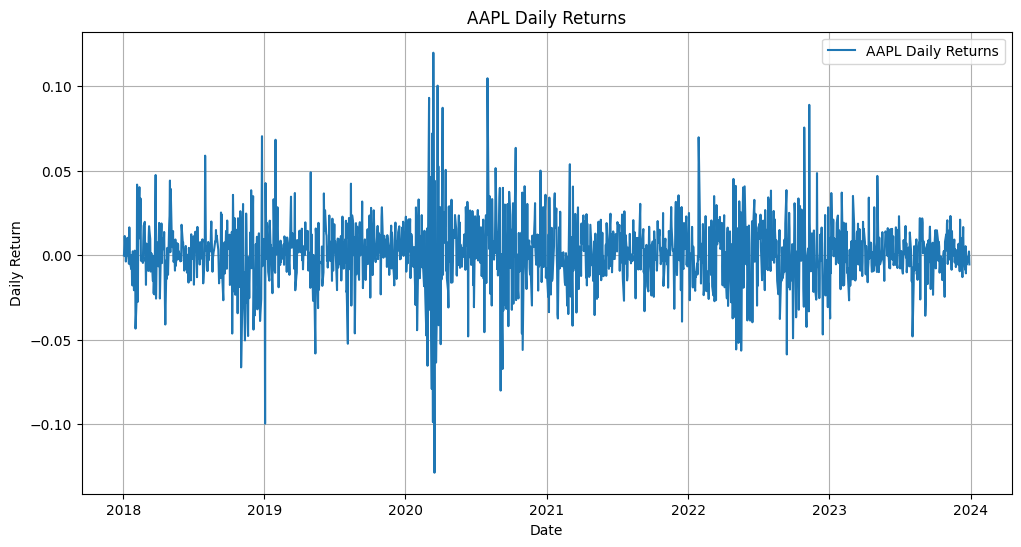

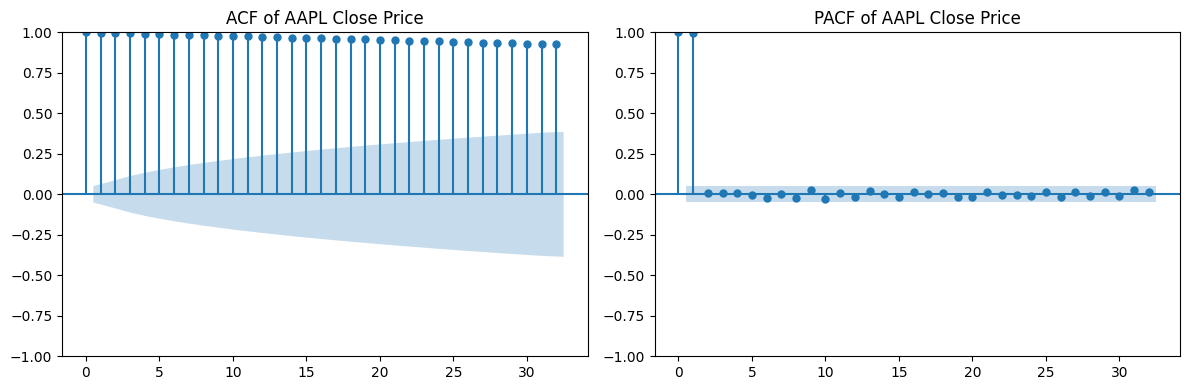

In [4]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis (EDA) ---")

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='AAPL Close Price')
plt.title('AAPL Daily Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data_filled['Volume']['AAPL'], label='AAPL Volume', color='orange')
plt.title('AAPL Daily Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA200'] = stock_data['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='AAPL Close Price')
plt.plot(stock_data['MA50'], label='50-Day Moving Average', color='red')
plt.plot(stock_data['MA200'], label='200-Day Moving Average', color='green')
plt.title('AAPL Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

stock_data['Daily_Return'] = stock_data['Close'].pct_change()

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Daily_Return'], label='AAPL Daily Returns')
plt.title('AAPL Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stock_data['Close'].dropna(), ax=axes[0], title='ACF of AAPL Close Price')
plot_pacf(stock_data['Close'].dropna(), ax=axes[1], title='PACF of AAPL Close Price')
plt.tight_layout()
plt.show()

In [5]:
# --- 3. Feature Engineering ---
print("\n--- 3. Feature Engineering ---")

for lag in [1, 3, 7]:
    stock_data[f'Lagged_Close_{lag}'] = stock_data['Close'].shift(lag)
    stock_data[f'Lagged_Volume_{lag}'] = data_filled['Volume']['AAPL'].shift(lag)
    stock_data[f'Lagged_Return_{lag}'] = stock_data['Daily_Return'].shift(lag)


stock_data['Rolling_Mean_7D'] = stock_data['Close'].rolling(window=7).mean().shift(1)
stock_data['Rolling_Mean_30D'] = stock_data['Close'].rolling(window=30).mean().shift(1)

stock_data['Volume_Change'] = data_filled['Volume']['AAPL'].pct_change()

stock_data_processed = stock_data.dropna()
print("\nProcessed Data with Features Head:")
print(stock_data_processed.head())



--- 3. Feature Engineering ---

Processed Data with Features Head:
                Close       MA50      MA200  Daily_Return  Lagged_Close_1  \
Date                                                                        
2018-10-16  52.861179  52.264834  44.908280      0.022037       51.721390   
2018-10-17  52.632748  52.335286  44.968822     -0.004321       52.861179   
2018-10-18  51.402534  52.380470  45.023248     -0.023374       52.632748   
2018-10-19  52.185402  52.433581  45.080648      0.015230       51.402534   
2018-10-22  52.504242  52.496020  45.137324      0.006110       52.185402   

            Lagged_Volume_1  Lagged_Return_1  Lagged_Close_3  Lagged_Volume_3  \
Date                                                                            
2018-10-16      123164000.0        -0.021386       51.028938      212497600.0   
2018-10-17      116736000.0         0.022037       52.851658      161351600.0   
2018-10-18       91541600.0        -0.004321       51.721390      12


--- 4. Modeling ---

--- 4.1 ARIMA Model ---
ADF Statistic: -0.6899105864055267
p-value: 0.8493456429721196
Critical Values:
   1%, -3.435359311744588
   5%, -2.863752202145595
   10%, -2.5679477886494775


<ipython-input-6-3127b1dbd23c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_processed['Close_Diff'] = stock_data_processed['Close'].diff().dropna()



ADF Statistic after Differencing: -37.625547431377804
p-value after Differencing: 0.0
Critical Values after Differencing:
   1%, -3.435359311744588
   5%, -2.863752202145595
   10%, -2.5679477886494775


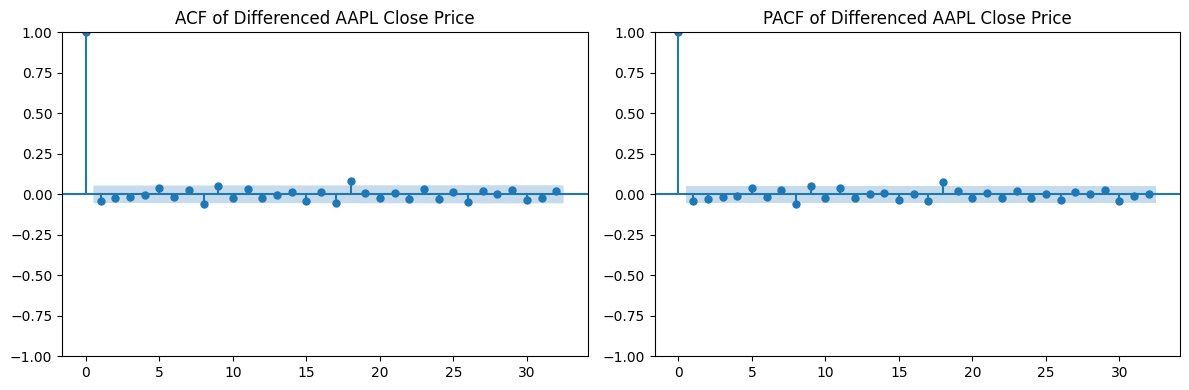

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Close_Diff   No. Observations:                 1047
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2380.379
Date:                Wed, 29 Jan 2025   AIC                           4766.757
Time:                        12:52:52   BIC                           4781.615
Sample:                             0   HQIC                          4772.392
                               - 1047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0632      0.023     -2.693      0.007      -0.109      -0.017
ma.L1         -1.0000      0.159     -6.301      0.000      -1.311      -0.689
sigma2         5.5111      0.890      6.192      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


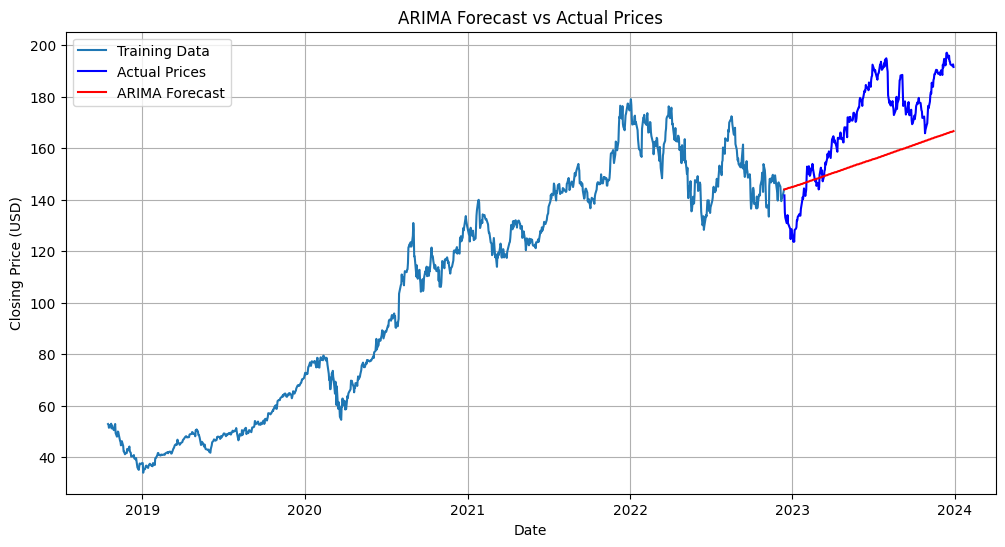


--- 4.2 Gradient Boosting Model ---

Best Gradient Boosting Model Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


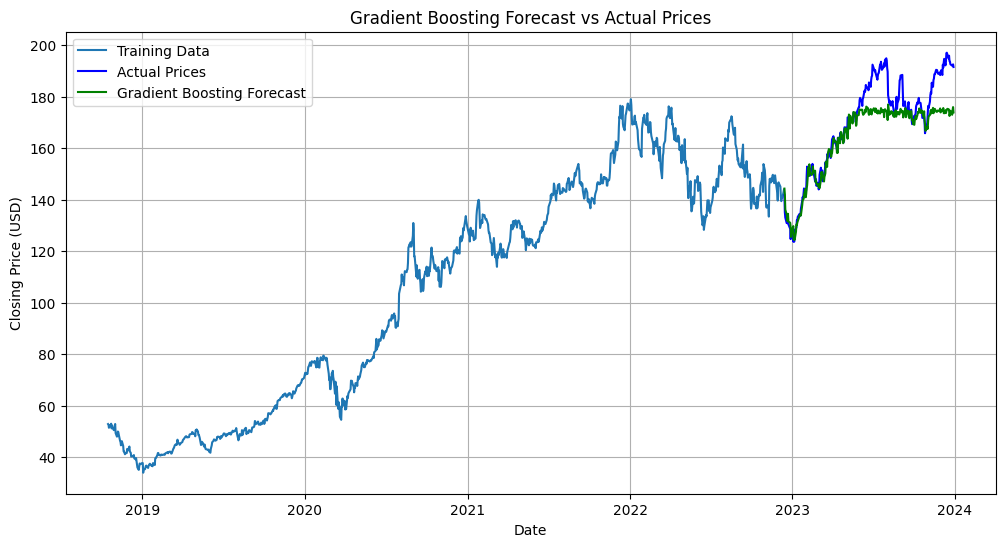

In [6]:
# --- 4. Modeling ---
print("\n--- 4. Modeling ---")

# --- 4.1 ARIMA Model ---
print("\n--- 4.1 ARIMA Model ---")

adf_result = adfuller(stock_data_processed['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}, {value}')

stock_data_processed['Close_Diff'] = stock_data_processed['Close'].diff().dropna()


adf_result_diff = adfuller(stock_data_processed['Close_Diff'].dropna())
print(f'\nADF Statistic after Differencing: {adf_result_diff[0]}')
print(f'p-value after Differencing: {adf_result_diff[1]}')
print('Critical Values after Differencing:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}, {value}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stock_data_processed['Close_Diff'].dropna(), ax=axes[0], title='ACF of Differenced AAPL Close Price')
plot_pacf(stock_data_processed['Close_Diff'].dropna(), ax=axes[1], title='PACF of Differenced AAPL Close Price')
plt.tight_layout()
plt.show()

train_data_arima = stock_data_processed['Close'][:int(0.8*len(stock_data_processed))]
test_data_arima = stock_data_processed['Close'][int(0.8*len(stock_data_processed)):]
train_diff_arima = stock_data_processed['Close_Diff'][:int(0.8*len(stock_data_processed))].dropna() # Use differenced for training

# ARIMA Model Training and Prediction
p, d, q = 1, 1, 1
arima_model = ARIMA(train_diff_arima, order=(p, d, q))
arima_result = arima_model.fit()
print(arima_result.summary())


forecast_steps = len(test_data_arima)
arima_forecast_diff = arima_result.forecast(steps=forecast_steps)


history = train_data_arima.iloc[-1]
arima_forecast = []
for y_diff in arima_forecast_diff:
    y = history + y_diff
    arima_forecast.append(y)
    history = y

arima_forecast_series = pd.Series(arima_forecast, index=test_data_arima.index)

# Plotting ARIMA forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train_data_arima, label='Training Data')
plt.plot(test_data_arima, label='Actual Prices', color='blue')
plt.plot(arima_forecast_series, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# --- 4.2 Gradient Boosting Model ---
print("\n--- 4.2 Gradient Boosting Model ---")


features = [col for col in stock_data_processed.columns if col not in ['Close', 'Daily_Return', 'Close_Diff', 'MA50', 'MA200']]
target = 'Close'

X = stock_data_processed[features]
y = stock_data_processed[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200], #, 300],
    'learning_rate': [0.01, 0.05], #, 0.1],
    'max_depth': [3, 4] #, 5]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_gb_model = grid_search.best_estimator_
print("\nBest Gradient Boosting Model Parameters:", grid_search.best_params_)

# Gradient Boosting Model Prediction
gb_forecast = best_gb_model.predict(X_test_scaled)

# Plotting Gradient Boosting forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values, label='Training Data')
plt.plot(y_test.index, y_test.values, label='Actual Prices', color='blue')
plt.plot(y_test.index, gb_forecast, label='Gradient Boosting Forecast', color='green')
plt.title('Gradient Boosting Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# --- 5. Model Evaluation ---
print("\n--- 5. Model Evaluation ---")

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'--- {model_name} Model Evaluation ---')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2f}%')
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Evaluating ARIMA model
arima_metrics = evaluate_model(test_data_arima, arima_forecast_series, 'ARIMA')

# Evaluating Gradient Boosting model
gb_metrics = evaluate_model(y_test, gb_forecast, 'Gradient Boosting')

# Comparision metrics
print("\n--- Model Comparison ---")
print("ARIMA Metrics:", arima_metrics)
print("Gradient Boosting Metrics:", gb_metrics)


--- 5. Model Evaluation ---
--- ARIMA Model Evaluation ---
RMSE: 19.76
MAE: 17.23
MAPE: 9.83%
--- Gradient Boosting Model Evaluation ---
RMSE: 8.93
MAE: 6.17
MAPE: 3.40%

--- Model Comparison ---
ARIMA Metrics: {'RMSE': 19.76043330448873, 'MAE': 17.22518780028607, 'MAPE': 9.832299181131491}
Gradient Boosting Metrics: {'RMSE': 8.93121218496378, 'MAE': 6.172365935235015, 'MAPE': 3.400187488737815}
